In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('D* results Nov 23 - Jun 25.csv')

# Convert deliveryStart to datetime
df['Delivery start'] = pd.to_datetime(df['Delivery start'])

# Clean up the column name - remove extra spaces and ensure single column
df.columns = df.columns.str.strip()
if 'EFA block of the day ' in df.columns:
    df = df.rename(columns={'EFA block of the day ': 'EFA block of the day'})

# Fill missing delivery dates and EFA blocks
for index, row in df.iterrows():
    if pd.isna(row['Delivery date']) or pd.isna(row['EFA block of the day']):
        start_time = row['Delivery start']
        hour = start_time.hour
        
        # EFA blocks: 
        # Block 1: 23:00-03:00 (delivery date is next day)
        # Block 2: 03:00-07:00 (delivery date is same day as 03:00)
        # Block 3: 07:00-11:00 (delivery date is same day)
        # Block 4: 11:00-15:00 (delivery date is same day)
        # Block 5: 15:00-19:00 (delivery date is same day)
        # Block 6: 19:00-23:00 (delivery date is same day)
        
        if hour >= 23:  # 23:00-23:59
            efa_block = 1
            delivery_date = (start_time + pd.Timedelta(days=1)).strftime('%d/%m/%Y')
        elif hour < 3:  # 00:00-02:59
            efa_block = 1
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 7:  # 03:00-06:59
            efa_block = 2
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 11:  # 07:00-10:59
            efa_block = 3
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 15:  # 11:00-14:59
            efa_block = 4
            delivery_date = start_time.strftime('%d/%m/%Y')
        elif hour < 19:  # 15:00-18:59
            efa_block = 5
            delivery_date = start_time.strftime('%d/%m/%Y')
        else:  # 19:00-22:59
            efa_block = 6
            delivery_date = start_time.strftime('%d/%m/%Y')
        
        # Update missing values
        if pd.isna(row['Delivery date']):
            df.at[index, 'Delivery date'] = delivery_date
        if pd.isna(row['EFA block of the day']):
            df.at[index, 'EFA block of the day'] = efa_block

# Save updated file
df.to_csv('D* results Nov 23 - Jun 25_cleaned.csv', index=False)
print("File updated successfully!")
print(f"Total rows processed: {len(df)}")
print(f"Unique EFA blocks: {sorted(df['EFA block of the day'].unique())}")

/var/folders/hh/yly126sx0nv7wh7rwnh8n_pm0000gn/T/ipykernel_22533/568803902.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '03/11/2023' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Delivery date'] = delivery_date


File updated successfully!
Total rows processed: 21822
Unique EFA blocks: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]


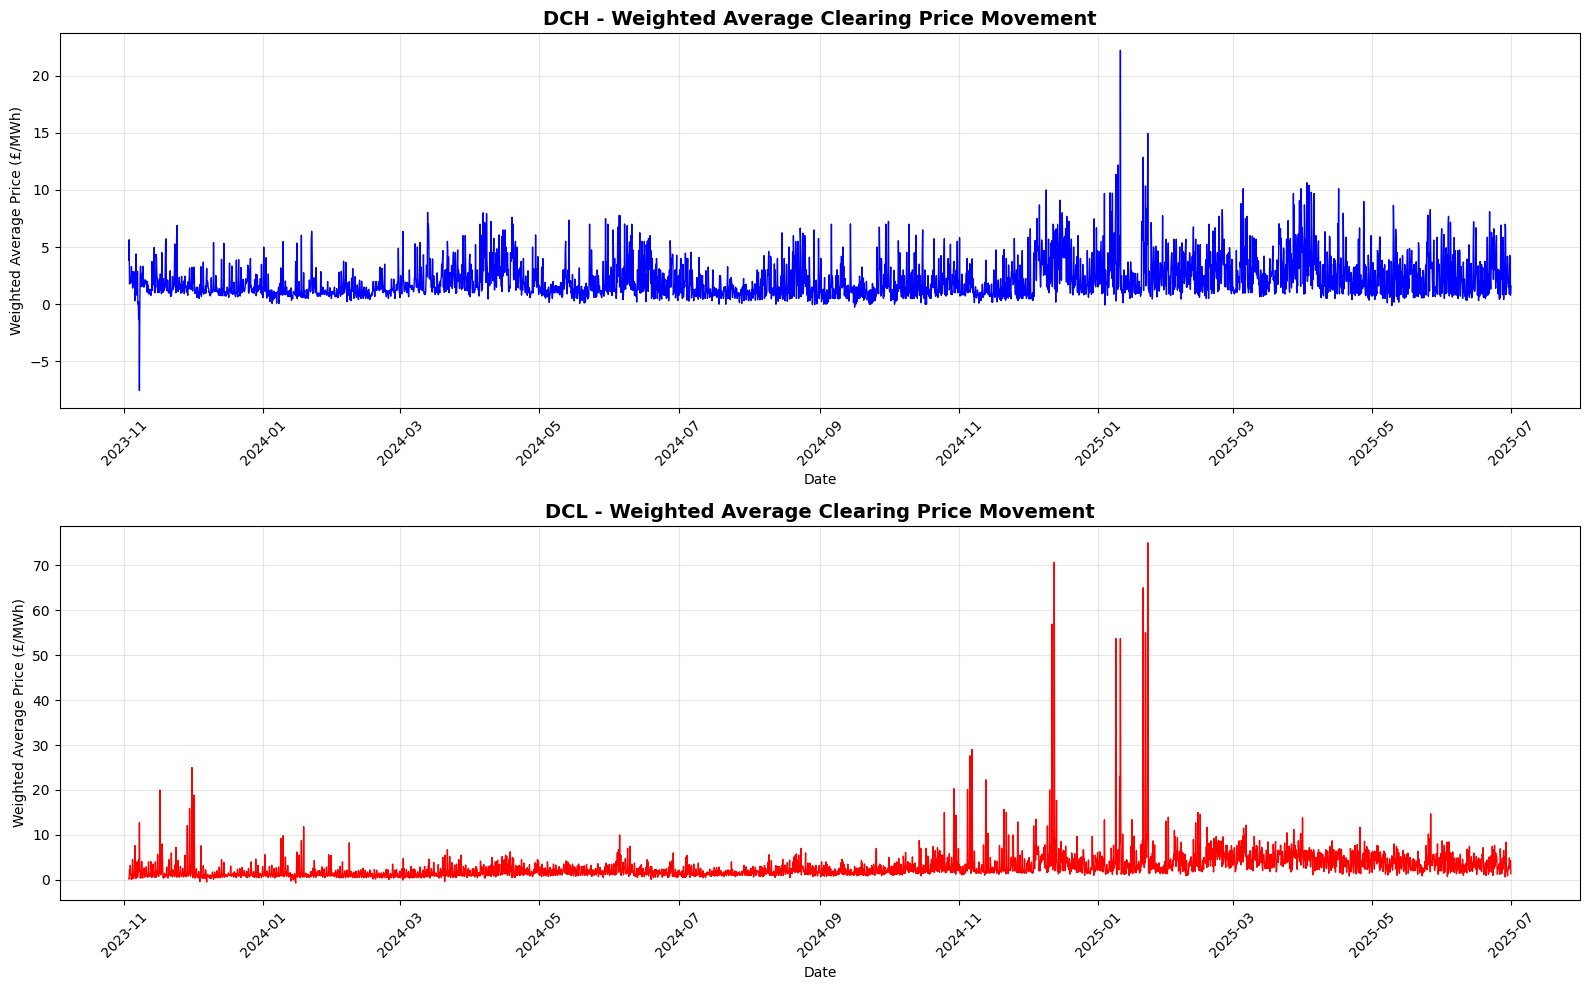

Summary Statistics for Weighted Average Prices:

DCH Product:
Mean: £2.20/MWh
Std: £1.77/MWh
Min: £-7.56/MWh
Max: £22.22/MWh

DCL Product:
Mean: £2.87/MWh
Std: £3.54/MWh
Min: £-0.71/MWh
Max: £75.00/MWh

Data points: 3635 DCH records, 3635 DCL records


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

# Read the cleaned data
df = pd.read_csv('D* results Nov 23 - Jun 25_cleaned.csv')

# Convert datetime columns
df['Delivery start'] = pd.to_datetime(df['Delivery start'])
df['Delivery date'] = pd.to_datetime(df['Delivery date'], format='%d/%m/%Y')

# Filter for DCH and DCL products only
dc_products = df[df['Product'].isin(['DCH', 'DCL'])].copy()

# Calculate weighted average price for each product, day, and EFA block
dc_products['Price_Volume'] = dc_products['Clearing price'] * dc_products['Cleared Volume']

weighted_avg = dc_products.groupby(['Product', 'Delivery date', 'EFA block of the day']).agg({
    'Price_Volume': 'sum',
    'Cleared Volume': 'sum'
}).reset_index()

weighted_avg['Weighted_Avg_Price'] = weighted_avg['Price_Volume'] / weighted_avg['Cleared Volume']

# Create datetime index combining date and EFA block for chronological ordering
weighted_avg['DateTime_Block'] = weighted_avg['Delivery date'] + pd.to_timedelta((weighted_avg['EFA block of the day'] - 1) * 4, unit='h')

# Sort by the new datetime index
weighted_avg = weighted_avg.sort_values('DateTime_Block')

# Create the chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot DCH as single line
dch_data = weighted_avg[weighted_avg['Product'] == 'DCH'].reset_index(drop=True)
ax1.plot(dch_data['DateTime_Block'], dch_data['Weighted_Avg_Price'], 
         color='blue', linewidth=1)

ax1.set_title('DCH - Weighted Average Clearing Price Movement', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Weighted Average Price (£/MWh)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot DCL as single line
dcl_data = weighted_avg[weighted_avg['Product'] == 'DCL'].reset_index(drop=True)
ax2.plot(dcl_data['DateTime_Block'], dcl_data['Weighted_Avg_Price'], 
         color='red', linewidth=1)

ax2.set_title('DCL - Weighted Average Clearing Price Movement', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Weighted Average Price (£/MWh)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display summary statistics
print("Summary Statistics for Weighted Average Prices:")
print("\nDCH Product:")
print(f"Mean: £{dch_data['Weighted_Avg_Price'].mean():.2f}/MWh")
print(f"Std: £{dch_data['Weighted_Avg_Price'].std():.2f}/MWh")
print(f"Min: £{dch_data['Weighted_Avg_Price'].min():.2f}/MWh")
print(f"Max: £{dch_data['Weighted_Avg_Price'].max():.2f}/MWh")

print("\nDCL Product:")
print(f"Mean: £{dcl_data['Weighted_Avg_Price'].mean():.2f}/MWh")
print(f"Std: £{dcl_data['Weighted_Avg_Price'].std():.2f}/MWh")
print(f"Min: £{dcl_data['Weighted_Avg_Price'].min():.2f}/MWh")
print(f"Max: £{dcl_data['Weighted_Avg_Price'].max():.2f}/MWh")

print(f"\nData points: {len(dch_data)} DCH records, {len(dcl_data)} DCL records")

In [8]:
# Create separate CSV files for DCH and DCL weighted averages
import pandas as pd

# Read the cleaned data
df = pd.read_csv('D* results Nov 23 - Jun 25_cleaned.csv')


# Filter for DCH and DCL products only
dc_products = df[df['Product'].isin(['DCH', 'DCL'])].copy()

# Calculate weighted average price for each product, day, and EFA block
dc_products['Price_Volume'] = dc_products['Clearing price'] * dc_products['Cleared Volume']

weighted_avg = dc_products.groupby(['Product', 'Delivery date', 'EFA block of the day']).agg({
    'Price_Volume': 'sum',
    'Cleared Volume': 'sum'
}).reset_index()

weighted_avg['Weighted_Avg_Clearing_Price'] = weighted_avg['Price_Volume'] / weighted_avg['Cleared Volume']

# Create separate DataFrames for DCH and DCL
dch_data = weighted_avg[weighted_avg['Product'] == 'DCH'][['Delivery date', 'EFA block of the day', 'Weighted_Avg_Clearing_Price']].copy()
dcl_data = weighted_avg[weighted_avg['Product'] == 'DCL'][['Delivery date', 'EFA block of the day', 'Weighted_Avg_Clearing_Price']].copy()

# Sort by delivery date and EFA block
dch_data = dch_data.sort_values(['Delivery date', 'EFA block of the day']).reset_index(drop=True)
dcl_data = dcl_data.sort_values(['Delivery date', 'EFA block of the day']).reset_index(drop=True)

# Format delivery date as DD/MM/YYYY for consistency
dch_data['Delivery date'] = pd.to_datetime(dch_data['Delivery date'], dayfirst=True).dt.strftime('%d/%m/%Y')
dcl_data['Delivery date'] = pd.to_datetime(dcl_data['Delivery date'], dayfirst=True).dt.strftime('%d/%m/%Y')

# Save to separate CSV files
dch_data.to_csv('DCH_Weighted_Average_Prices.csv', index=False)
dcl_data.to_csv('DCL_Weighted_Average_Prices.csv', index=False)

print("CSV files created successfully!")
print(f"DCH file: {len(dch_data)} records saved to 'DCH_Weighted_Average_Prices.csv'")
print(f"DCL file: {len(dcl_data)} records saved to 'DCL_Weighted_Average_Prices.csv'")

print("\nDCH Preview:")
print(dch_data.head(10))

print("\nDCL Preview:")
print(dcl_data.head(10))

CSV files created successfully!
DCH file: 3635 records saved to 'DCH_Weighted_Average_Prices.csv'
DCL file: 3635 records saved to 'DCL_Weighted_Average_Prices.csv'

DCH Preview:
  Delivery date  EFA block of the day  Weighted_Avg_Clearing_Price
0    01/01/2024                   1.0                         1.49
1    01/01/2024                   2.0                         5.00
2    01/01/2024                   3.0                         2.31
3    01/01/2024                   4.0                         1.25
4    01/01/2024                   5.0                         2.21
5    01/01/2024                   6.0                         1.10
6    01/01/2025                   1.0                         3.00
7    01/01/2025                   2.0                         4.50
8    01/01/2025                   3.0                         2.50
9    01/01/2025                   4.0                         4.60

DCL Preview:
  Delivery date  EFA block of the day  Weighted_Avg_Clearing_Price
0   

In [ ]:
# Overlaying DCH prices from 2022,2023 and 2024 for comparison
